**INTRODUCTION**

O objetivo desse notebook é utilizar vários models preditivos para detectar se uma transação é **fraudulenta** ou **não fraudulenta**. Como descrito no conjunto de dados, as "features" são escalonadas e os nomes das "features" não são mostrados por razão de privacidade.

### Objetivos

- Enteder a distribuição dos dados
- Criar um "sub-conjuntos de dados" de razão 50/50 com as transações **Fraudulentas** e **Não fraudulentas**.
- Determinar os classificadores a serem usados e decidir qual tem maior acurácia
- Criar uma rede neural e comparar a acurácia com o clasificador
- Entender erros comuns presentes em conjuntos de dados desbalanceados.

### Glossário

Apesar do notebook estar escrito em português, alguns termos serão escritos em inglês, pois a a tradução poderia gerar uma confusão em quem já está acostumado aos termos em inglês. Aqui um pequeno glossário destes termos:

- **Oversample**: ou "superamostra", consiste em  aumentar as amostras da classe minoritária, com intuito de balanceá-la com a classe majoritária. Aplicar essa técnica geralmente é conhecido como **oversampling (superamostragem)** e o conjunto de dados fica conhecido como **oversampled (superamostrado)**
- **Undersample**: ou "subamostra", consiste em excluir amostras da classe majoritária, com intuito de balanceá-la com a classe minoritária. Aplicar essa técnica geralmente é conhecido como **undersampling (subamostragem)** e o conjunto de dados fica conhecido como **undersampled (subamostrado)**.
- **Cross-validation**: validação cruzada
- **accuracy**: acurácia
- **confusion matrix**: matriz de confusão

### Corrigindo erros comuns em conjuntos de dados desbalanceados

- Nunca testar em conjuntos de dados "oversampled" ou "undersampled"
- Caso for implementada uma "cross-validation", lembrar de aplicar o "oversample" ou "undersample" nos dados de treino **durante** a validação, não antes
- Não usar a **accuracy** como métrica para ocnjunto de dados desbalanceados. Ao invés disso, usar **f1-score**, **precision/recall score** ou **confusion matrix**.

### Entendendo os dados

Com exceção das colunas **transaction** e **amount**, não sabemos o que são as outras colunas (por razão de privacidade, como dito anteriormente). A única coisa que sabemos das colunas desconhecidas é que elas estão escalonadas.

- A montante de transações e relativamente **pequena**. A média é aproximadamente **USD 88**
- Não há valores nulos
- A grande maioria das transações são **não fraudulentas** (99.83%), enquanto transações **fraudulentas** ocorrem apenas em 0.17% do conjunto de dados.

### Informações sobre as "features"

- **PCA**: a descrição dos dados nos diz que as "features" passaram pela transformação PCA(Principal Component Analysis), com intuito de reduzir as dimensões dos dados (exceto **time** e **amount**)
- **Escalonamento**: antes da aplicação do PCA, os dados foram escalonados.   

# Bibliotecas necessárias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
import itertools

from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, precision_recall_curve, average_precision_score, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV, ShuffleSplit, learning_curve, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

ModuleNotFoundError: No module named 'keras.layers.core'

# Carregamento dos dados

In [ ]:
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Análise dos dados

### Shape

In [ ]:
print('Linhas: ', df.shape[0])
print('Colunas: ', df.shape[1])

Linhas:  284807
Colunas:  31


### Descrição

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


### Valores nulos

In [ ]:
df.isnull().sum().max()

0

### Colunas

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### Porcentagem das transações fraudulentas VERSUS não fraudulentas

In [ ]:
print('Transações não fraudulentas: ', round(df['Class'].value_counts()[0] / len(df) * 100, 2), '% dos dados')
print('Transações fraudulentas: ', round(df['Class'].value_counts()[1] / len(df) * 100, 2), '% dos dados')

Transações não fraudulentas:  99.83 % dos dados
Transações fraudulentas:  0.17 % dos dados


O conjunto de dados é bastante desbalanceado. Grande parte das transações é do tipo **não fradulenta**. Se esse conjunto de dados for usado como base para um modelo de predição, o algoritmo irá assumir que a maioria das transações é do tipo **não fradulenta**, e não queremos que nosso modelo assuma e sim que detecte padrões que deem sinais de fraude.

### Distribuição da classe

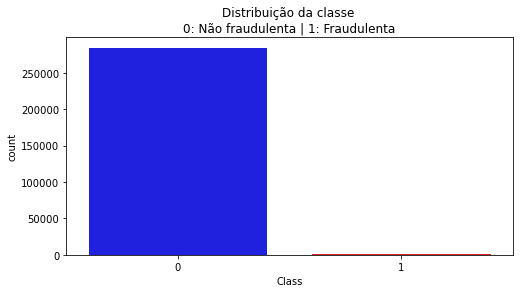

In [ ]:
plt.figure(figsize=(8, 4))

sns.countplot('Class', data=df, palette=['b', 'r'])
plt.title('Distribuição da classe \n0: Não fraudulenta | 1: Fraudulenta')

plt.show()

# Escalonamento e ditribuição dos dados

Nessa fase do notebook, iremos primeiro escalonar as colunas **Time** e **Amount** e depois criar uma "subsample" do conjunto de dados com quantidade iguais de casos fraudulentos e não fraudulentos.

Nesse caso, a "subsample" será um dataframe com proporção 50/50 de transações fraudulentas e não fraudulentas, ou seja, teremos 50% de dados para cada tipo de transação.

### Mas para quê criar uma "subsample"?

Para evitar esses dois problemas:
- **Overfitting**: o modelo de classificação irá assumir que a maioria das transações é do tipo **não fraudulenta**
- **Correlações erradas**: como não conhecemos a maioria das "features", elas são úteis para entender como cada "feature"  influencia o resultado (fraudulento ou não fraudulento). Em conjunto de dados desbalanceados, o modelo não consegue perceber a verdadeira correlação entre as "features"  e a "classe".

### Detalhes importantes:

- **scaled amount** e **scaled time** são as colunas com dados escalonados
- Há **492** caso de fraude no conjunto de dados, então pegaremos aleatoriamente 492 casos não fraudulentos para criar o novo "dataframe"
- Depois, uniremos os 492 casos de fraude e não fraude para **criar o subsample**.

In [ ]:
# Reescala a distribuição para ficar com média 0 e desvio-padrão 1
std_scaler = StandardScaler()
# Utiliza o IQR (Inter Quartile Range) no escalonamento
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [ ]:
# Armazena os dados das colunas criadas anteriormente
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# Deleta as colunas criadas
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)

# Insere os valores das colunas criadas na 1ª e 2ª colunas do dataframe, respectivamente
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Dividir os dados (dataframe original)

Antes de aplicar o **undersampling**, é importante separar o "dataframe" original. O objetivo disso é que possamos treinar o modelo nos dados com **undersampling** e testar nos dados originais.

In [ ]:
# Features
X = df.drop('Class', axis=1)
# Target
y = df['Class']

# Separa os dados de maneira estratificada (mantendo as proporções originais)
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):

    # Armazena os dados originais
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # Transforma em array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values

    # Verifica se as distribuições de treino e teste são similares
    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

    print('Distribuições:')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/ len(original_ytest))
    print('-' * 100)

Distribuições:
[0.99827514 0.00172486]
[0.998262 0.001738]
----------------------------------------------------------------------------------------------------
Distribuições:
[0.99827514 0.00172486]
[0.998262 0.001738]
----------------------------------------------------------------------------------------------------
Distribuições:
[0.99827076 0.00172924]
[0.99827952 0.00172048]
----------------------------------------------------------------------------------------------------
Distribuições:
[0.99827076 0.00172924]
[0.99827952 0.00172048]
----------------------------------------------------------------------------------------------------
Distribuições:
[0.99827076 0.00172924]
[0.99827952 0.00172048]
----------------------------------------------------------------------------------------------------


### "Undersampling" aleatória

Nessa fase será implementada a técnica "random undersampling", que basicamente consiste em remover dados para tornar o conjuntos de dados **mais balanceado**.

Passos:
- Determinar o quanto nossas classes são desbalanceadas
- Uma vez determinadas quantas instancias de **transações fraudulentas** (classe 1), vamos selecionar o mesmo número de transações **não fraudulentas** (classe 0).
- Após isso, teremos um conjunto de dados com proporção 50/50. Depois, vamos embaralhar os dados.

Um dos problemas dessas técnica é que temos a **perda de informações**. Nesse caso, usaremos apenas **492** transações não fraudulentas, de um total de **284,315**.

In [ ]:
# Pegar uma amostra aleatória. frac = 1 significa que a fração conterá todos os dados
df = df.sample(frac=1)

# Transações fraudulentas
fraud_df = df.loc[df['Class'] == 1]
# Transações não fraudulentas (a amostra terá tamanho de 492)
non_fraud_df = df.loc[df['Class'] == 0][:492]

# concatenando os dataframes anteriores
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# novo dataframe com a amostra aleatória dos dataframes anteriores. Novamente, a fração conterá todos os dados.
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
165598,0.041780,0.385801,2.112579,-0.978592,-2.531591,-1.672016,1.621659,3.410626,-1.522773,0.940170,...,0.123173,0.241275,0.658909,0.137661,0.604387,-0.114413,-0.067851,0.047220,-0.016706,0
143731,3.056941,0.010385,-2.207631,3.259076,-5.436365,3.684737,-3.066401,-0.671323,-3.696178,1.822272,...,0.808336,0.920899,0.037675,0.026754,-0.791489,0.176493,-0.136312,1.087585,0.373834,1
224074,-0.159016,0.692525,1.930818,0.623923,-0.646099,3.797532,0.482857,-0.172961,0.282314,-0.243303,...,-0.184651,0.297274,1.039541,-0.045399,-0.054673,0.286479,0.245516,-0.024549,-0.049671,0
10568,-0.293440,-0.789154,-5.268053,9.067613,-15.960728,10.296603,-4.708241,-3.395375,-11.161057,5.499963,...,1.455878,2.004110,0.191058,0.622928,-1.209264,-0.374799,0.648798,1.584697,0.720056,1
237107,-0.307413,0.756635,1.184891,3.152084,-6.134780,5.531252,1.733867,-1.816861,-0.916696,0.265568,...,0.336442,0.124236,-0.823865,-0.079887,0.028828,0.389711,0.060171,0.485187,0.326552,1


# Distribuição igualitária e correlações

Distruição das classes no novo dataset
1    0.5
0    0.5
Name: Class, dtype: float64


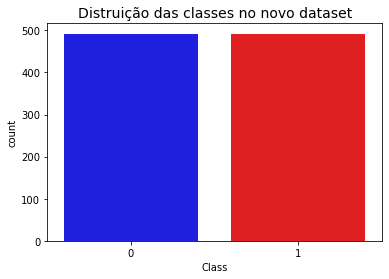

In [ ]:
print('Distruição das classes no novo dataset')
print(new_df['Class'].value_counts()/len(new_df))

# Distruição das classes no dataframe balanceado
sns.countplot('Class', data=new_df, palette=['b', 'r'])
plt.title('Distruição das classes no novo dataset', fontsize=14)

plt.show()

### Correlações

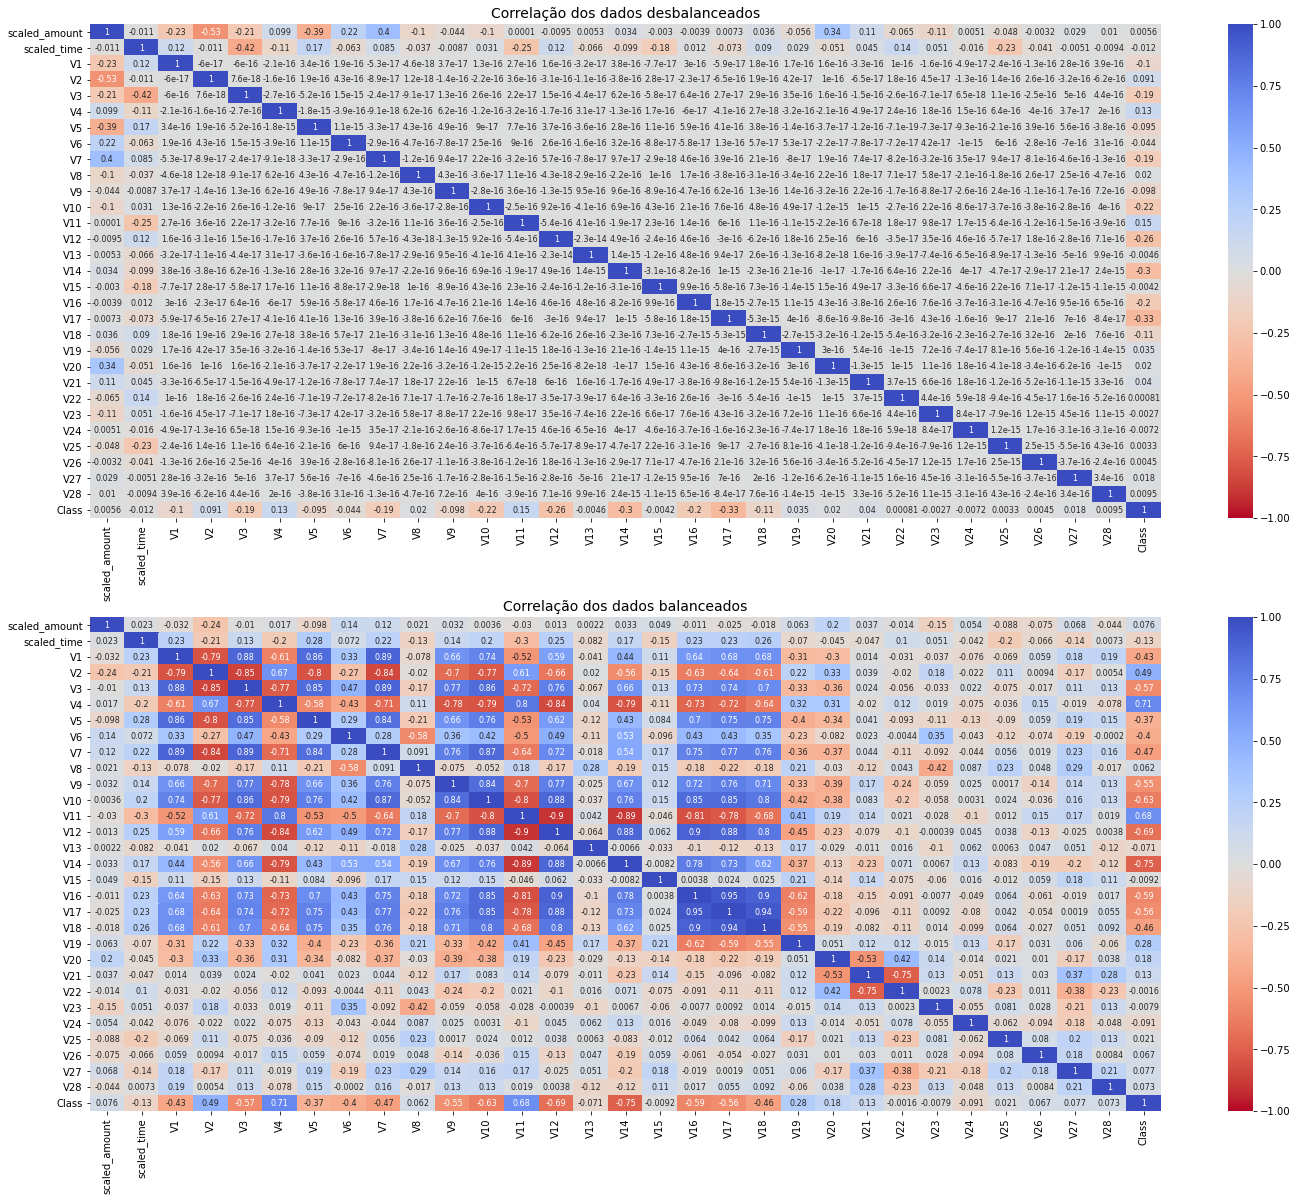

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# Correlação do dataframe original
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', vmin=-1, vmax=1,annot=True,  annot_kws={'size': 8}, ax=ax1)
ax1.set_title('Correlação dos dados desbalanceados', fontsize=14)

# Correlação do dataframe balanceado
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot=True, vmin=-1, vmax=1, annot_kws={'size': 8}, ax=ax2)
ax2.set_title('Correlação dos dados balanceados', fontsize=14)

plt.show()

É importante observar que na correlação dos **dados desbalanceados (df)** a grande maioria das features não possuiam correlações entre si (correlação = 0), já nos dados **balanceados (new_df)**, as correlações entre "features" eram bem mais nítidas.

- **Correlação negativa:** V16, V14, V12 e V10. Isso que dizer que, quanto menor seus valores, mais provável a transação ser fraudulenta
- **Correlação positiva:** V2, V4, e V11. Isso que dizer que, quanto maior seus valores, mais provável a transação ser fraudulenta.

### Boxplots

#### Classe negativa

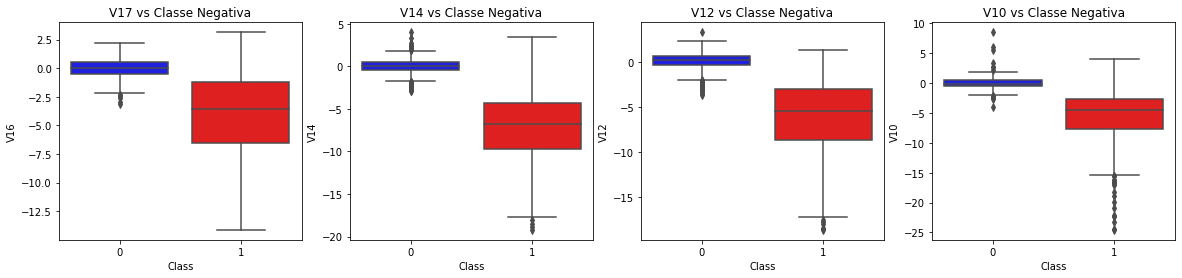

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ['b', 'r']

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Classe Negativa')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Classe Negativa')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Classe Negativa')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Classe Negativa')

plt.show()

# Remoção de outliers

O principal objetivo dessa seção é remover "outliers" extremos das "features" que possuem correlação alta com a classe.

### Método "Interquartile range" (distância interquartil)

- **Interquartile range (IQR):** O cálculo é feito pela diferença entre 75º percentil e o 25º percentil. Com isso podemos criar uma **limiar** entre o 75º e 25º e qualquer instância fora dessa limiar será excluida.


### Remoção de "outliers" "tradeoff"

Temos que ser cuidadosos com relação à limiar para a remoção de "outliers". Determinamos essa limiar multiplicando um número (1.5, por exemplo) pelo IQR. Quanto maior a limiar, menos "outliers" serão detectados (Se usarmos o número 3 na multiplicação, por exemplo) e quanto menor a limiar, mais "outliers" serão detectados. O melhor é focarmos apenas nos "outliers" extremos, assim diminuindo o risco de ocorrer a perda de informações, fazendo com que o modelo tenha acurácia menor.

### Passos:

- Primeiro iremos **visualizar as distribuições** de algumas "features" que iremos usar para elimiar os "outliers"
- Depois, **determinar a limiar** que usaremos, ou seja, decidir qual número iremos multiplicar com o IQR
    > q25 - limiar = limite inferior | q75 + limiar = limite superior
- Por último, criaremos a condição para exclusão, onde as intâncias que excederem os limites serão removidas.

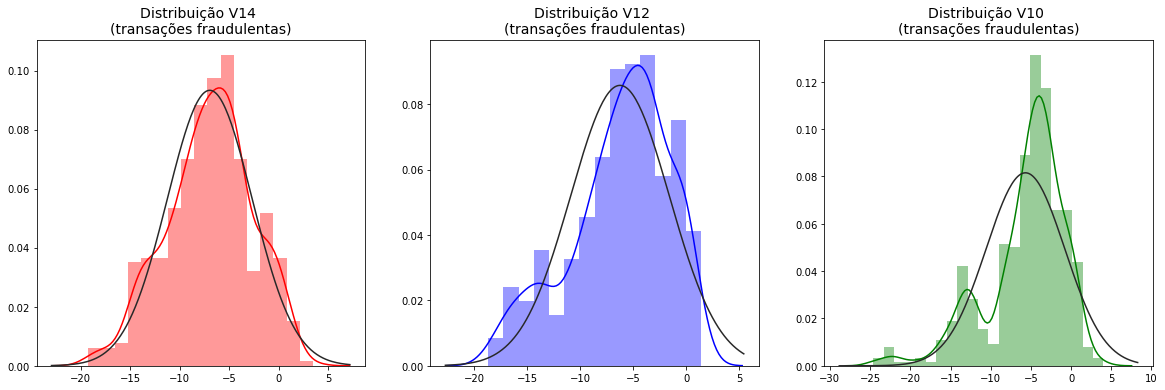

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='r')
ax1.set_title('Distribuição V14 \n(transações fraudulentas)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='b')
ax2.set_title('Distribuição V12 \n(transações fraudulentas)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='g')
ax3.set_title('Distribuição V10 \n(transações fraudulentas)', fontsize=14)

plt.show()

V14 é a única "feature" com uma distribuição normal comparada com as outras.

In [ ]:
# Remover os outliers de V14 (correlação negativa alta com a classe)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
# Valores do quartil 25 e quartil 75
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('QUARTIL 25: {} | QUARTIL 75: {}'.format(q25, q75))
# Interquartile range
v14_iqr = q75 - q25
print('IQR: ', v14_iqr)

# Limiar
v14_cut_off = v14_iqr * 1.5
# Limite superior e inferior
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('LIMIAR: ', v14_cut_off)
print('V14 LIMITE INFERIOR', v14_lower)
print('V14 LIMITE SUPERIOR', v14_upper)

# Ouliers (fora os limites estabelecidos anteriormente)
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('V14 QUANTIDADE DE OUTLIERS EM FRAUDES:', len(outliers))

# Novo dataframe sem os outliers
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)


# Remover os outliers de V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 LIMITE INFERIOR: {}'.format(v12_lower))
print('V12 LIMITE SUPERIOR: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]

print('V12 OUTLIERS: {}'.format(outliers))
print('V12 QUANTIDADE DE OUTLIERS EM FRAUDES: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('NÚMERO DE INSTÂNCIAS APÓS A REMOÇÃO DOS OUTLIERS: {}'.format(len(new_df)))
print('----' * 44)


# Remover os outliers de V10

v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 LIMITE INFERIOR: {}'.format(v10_lower))
print('V10 SUPERIOR: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]

print('V10 OUTLIERS: {}'.format(outliers))
print('V10 QUANTIDAADE DE OUTLIERS EM FRAUDES: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)


print('---' * 42)
print('NÚMERO DE INSTÂNCIAS APÓS A REMOÇÃO DOS OUTLIERS: {}'.format(len(new_df)))

QUARTIL 25: -9.692722964972385 | QUARTIL 75: -4.282820849486866
IQR:  5.409902115485519
LIMIAR:  8.114853173228278
V14 LIMITE INFERIOR -17.807576138200663
V14 LIMITE SUPERIOR 3.8320323237414122
V14 QUANTIDADE DE OUTLIERS EM FRAUDES: 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 LIMITE INFERIOR: -17.3430371579634
V12 LIMITE SUPERIOR: 5.776973384895937
V12 OUTLIERS: [-18.553697009645802, -18.047596570821604, -18.683714633344298, -18.4311310279993]
V12 QUANTIDADE DE OUTLIERS EM FRAUDES: 4
NÚMERO DE INSTÂNCIAS APÓS A REMOÇÃO DOS OUTLIERS: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 LIMITE INFERIOR: -14.89885463232024
V10 SUPERIOR: 4.920334958342141
V10 OUTLIERS: [-15.1237521803455, -19.836148851696, -15.2399619587112

### Boxplots sem os "outliers"

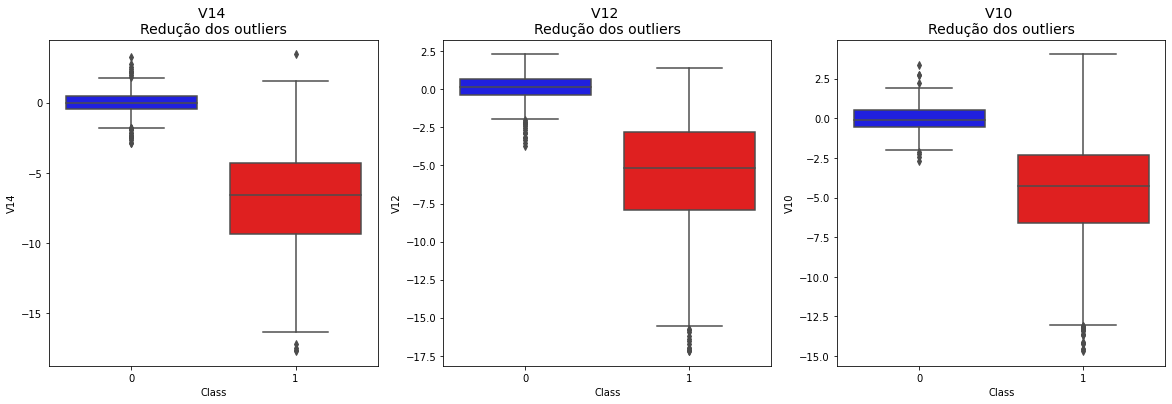

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

colors = ['b', 'r']

# V14
sns.boxplot(x='Class', y='V14', data = new_df, ax=ax1, palette=colors)
ax1.set_title('V14 \nRedução dos outliers', fontsize=14)

# V12
sns.boxplot(x='Class', y='V12', data = new_df, ax=ax2, palette=colors)
ax2.set_title('V12 \nRedução dos outliers', fontsize=14)

# V10
sns.boxplot(x='Class', y='V10', data = new_df, ax=ax3, palette=colors)
ax3.set_title('V10 \nRedução dos outliers', fontsize=14)


plt.show()

# Redução de dimensionalidade e clusterização

### Entendendo t-SNE:

Para entender esse algoritmo, é importante entender os seguintes termos:
- Distância Euclidiana
- Probabilidade Condicional
- Distribuição normal e T.

O algoritmo **t-SNE** pode agrupar de maneira bem acurada os casos fraudulentos ou não, principalmente pelo fato da "subsample" ser bem pequena. Isso indica que os modelos que usaremos terão um bom desempenho na separação das classes.

In [ ]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

# PCA
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)

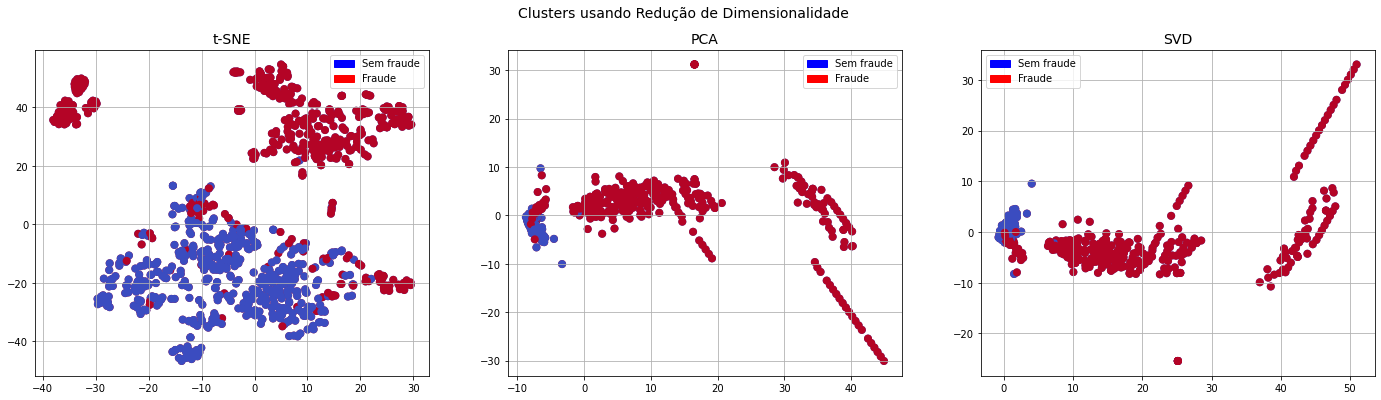

In [ ]:
# Cria a figura
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Clusters usando Redução de Dimensionalidade', fontsize=14)

# Cores
blue = mpatches.Patch(color='b', label='Sem fraude')
red = mpatches.Patch(color='r', label='Fraude')


# t-SNE
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y==0), cmap='coolwarm', label='Sem fraude', linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y==1), cmap='coolwarm', label='Fraude', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

# Desenha uma grade nas figuras
ax1.grid(True)
ax1.legend(handles=[blue, red])

# PCA
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y==0), cmap='coolwarm', label='Sem fraude', linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y==1), cmap='coolwarm', label='Fraude', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)
ax2.legend(handles=[blue, red])


# TruncatedSVD
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y==0), cmap='coolwarm', label='Sem Fraude', linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y==1), cmap='coolwarm', label='Fraude', linewidths=2)
ax3.set_title('SVD', fontsize=14)

ax3.grid(True)
ax3.legend(handles=[blue, red])


plt.show()

# Classificadores

Nessa seção iremos treinar 4 tipos de classificadores para decidir qual deles é mais efetivo na detecção de **transações fraudulentas**

### Considerações sobre a curva de aprendizado:

- Caso a diferença entre o "score" de treino e teste seja grande, isso pode significar que o modelo esteja sofrendo de **overfitting (alta variância)**
- Caso o "score" seja baixo no treino e no teste, o modelo pode estar sofrendo de **underfitting (alta bias)**.

### Split

In [ ]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Transformar em array
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

### Classificadores

In [ ]:
classifiers = {
    'LogisticRegression': LogisticRegression(),
    'KNearest': KNeighborsClassifier(),
    'SVC': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

### Validação cruzada

In [ ]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)

    training_score = cross_val_score(classifier, X_train, y_train, cv=5)

    print('Classificador: ', classifier.__class__.__name__, 'possui um score de', round(training_score.mean(), 2) * 100, '%')

Classificador:  LogisticRegression possui um score de 93.0 %
Classificador:  KNeighborsClassifier possui um score de 93.0 %
Classificador:  SVC possui um score de 92.0 %
Classificador:  DecisionTreeClassifier possui um score de 88.0 %


Com a validação cruzada, **LogisticRegression** se saiu melhor dentre os classificadores.

### Grid Search

In [ ]:
# Logistic Regression
# Parâmetros
log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# GridSearch
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
# Treinamento
grid_log_reg.fit(X_train, y_train)
# Melhores parâmetros
log_reg = grid_log_reg.best_estimator_



# Kneighbors
knears_params = {
    'n_neighbors': list(range(2, 5, 1)),
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_



# SVC
svc_params = {
    'C': [0.5, 0.7, 0.9, 1],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_



# DecisionTree
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(2, 4, 1)),
    'min_samples_leaf': list(range(5, 7, 1))
}

grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [ ]:
# Scores das validações cruzadas dos 4 modelos

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score: ', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score: ', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score: ', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.05%
Knears Neighbors Cross Validation Score:  92.99%
Support Vector Classifier Cross Validation Score:  93.65%
DecisionTree Classifier Cross Validation Score:  92.46%


Assim como no teste anterior, **LogisticRegression** se saiu melhor.

### "Undersample" durante a validação cruzada

Iremos fazer um "split" **estratificado** (com proporções iguais) utilizando os **dados originais (df)**.

In [ ]:
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print('Train: ', train_index, 'Test:', test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]

# Transformar em array
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

# Listas para armazenar os scores
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementação da técnica "NearMiss", apenas para ver a distribuição
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('Distribuição NearMiss: ', Counter(y_nearmiss))

# Validação cruzada da maneira correta
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])

    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train:  [ 54002  55030  55311 ... 284804 284805 284806] Test: [    0     1     2 ... 56968 56969 56970]
Train:  [     0      1      2 ... 284804 284805 284806] Test: [ 54002  55030  55311 ... 115404 116429 116778]
Train:  [     0      1      2 ... 284804 284805 284806] Test: [113918 113919 113920 ... 173079 173451 175483]
Train:  [     0      1      2 ... 284804 284805 284806] Test: [170877 170878 170879 ... 228851 228924 229223]
Train:  [     0      1      2 ... 228851 228924 229223] Test: [227841 227842 227843 ... 284804 284805 284806]
Distribuição NearMiss:  Counter({0: 492, 1: 492})


### Função para plotar as curvas de aprendizado dos modelos

In [ ]:
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    # Cria a figura com 4 subplots
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14), sharey=True)

    # Define os limites do eixo y
    if ylim is not None:
        plt.ylim(*ylim)


        # Primeiro "estimator"

        # Calcula a curva de aprendizado
        train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        # Média do treinamento
        train_scores_mean = np.mean(train_scores, axis=1)
        # Desvio-padrão do treinamento
        train_scores_std = np.std(train_scores, axis=1)
        # Média do teste
        test_scores_mean = np.mean(test_scores, axis=1)
        # Desvio-padrão do teste
        test_scores_std = np.std(test_scores, axis=1)
        # Preenche os eixos
        ax1.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="#ff9124")
        ax1.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        # Insere nos eixos os scores de treino
        ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",label="Score de treino")
        # Insere nos eixos os scores da validação cruzada
        ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Score da validação cruzada")
        # Título
        ax1.set_title("Logistic Regression", fontsize=14)
        # Legenda do eixo X
        ax1.set_xlabel('Training size (m)')
        # Legenda do eixo y
        ax1.set_ylabel('Score')
        # Desenha uma grande nos eixos
        ax1.grid(True)
        # Insere a legenda na melhor localização (onde não sobreponha as linhas desenhadas nos eixos)
        ax1.legend(loc="best")

        # Segundo "estimator"
        train_sizes, train_scores, test_scores = learning_curve(estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax2.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
        ax2.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Score de treino")
        ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
        ax2.set_title("Knears Neighbors", fontsize=14)
        ax2.set_xlabel('Training size (m)')
        ax2.set_ylabel('Score')
        ax2.grid(True)
        ax2.legend(loc="best")


        # Terceiro "estimator"
        train_sizes, train_scores, test_scores = learning_curve(estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax3.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="#ff9124")
        ax3.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Score de treino")
        ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
        ax3.set_title("Support Vector Classifier", fontsize=14)
        ax3.set_xlabel('Training size (m)')
        ax3.set_ylabel('Score')
        ax3.grid(True)
        ax3.legend(loc="best")


        # Quarto "estimator"
        train_sizes, train_scores, test_scores = learning_curve(estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax4.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="#ff9124")
        ax4.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
        ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label="Score de treino")
        ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff", label="Cross-validation score")
        ax4.set_title("Decision Tree Classifier", fontsize=14)
        ax4.set_xlabel('Training size (m)')
        ax4.set_ylabel('Score')
        ax4.grid(True)
        ax4.legend(loc="best")

        # Retorna a figura
        return plt

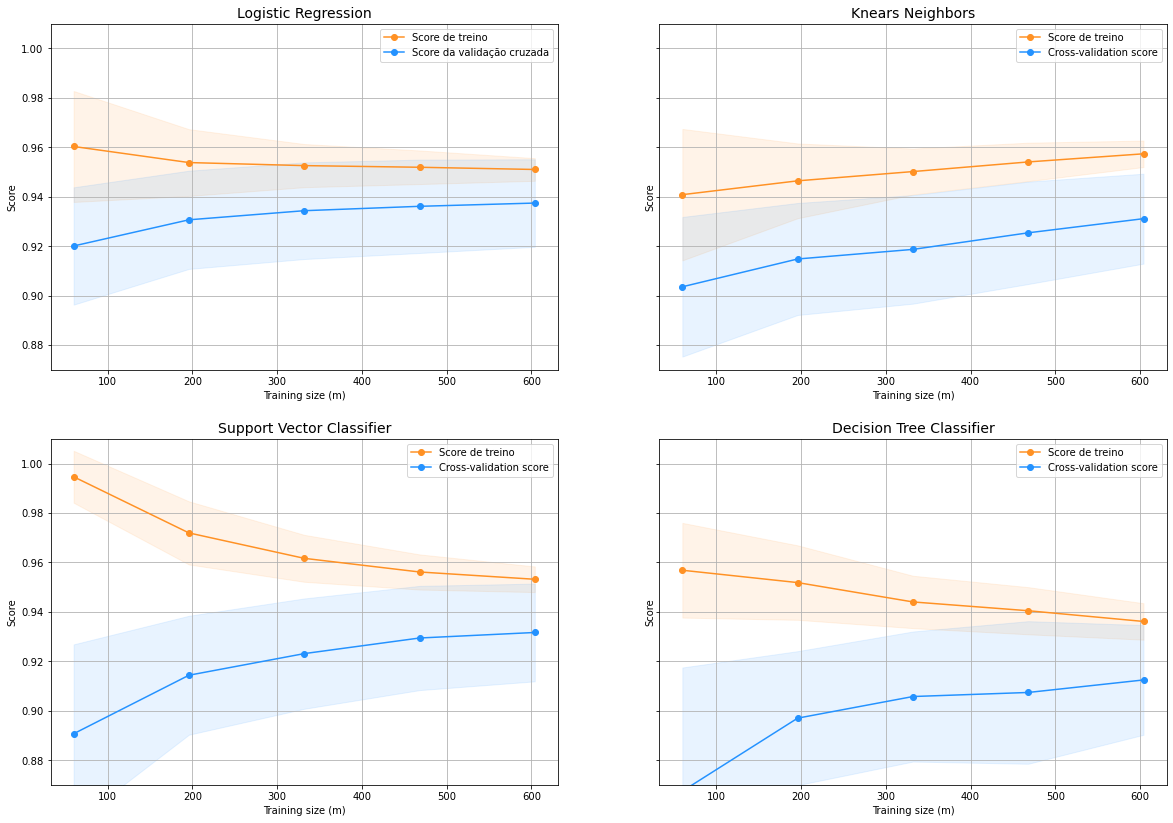

In [ ]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=-1);

O modelo **LogisticRegression**, além de apresentar "scores" altos no treino e na validação cruzada (isso que dizer que não houve **underfitting**), também mostrou que não há tanta diferença (gap) entre os "scores" de treino e teste, sinal de que houve **overfitting**.


### ROC AUC

Abaixo faremos a **predição cruzada** usando os 4 classificadores:

In [ ]:
# Logistic Regression
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method='decision_function')

# Knears Neighbors
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

# SVC
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method='decision_function')

# Decision Tree Classifier
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [ ]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9759809249973702
KNears Neighbors:  0.9276657666818613
Support Vector Classifier:  0.9711700971282302
Decision Tree Classifier:  0.9227216943090571


O modelo de **LogisticRegression** obteve um resultado melhor sobre os outros modelos.

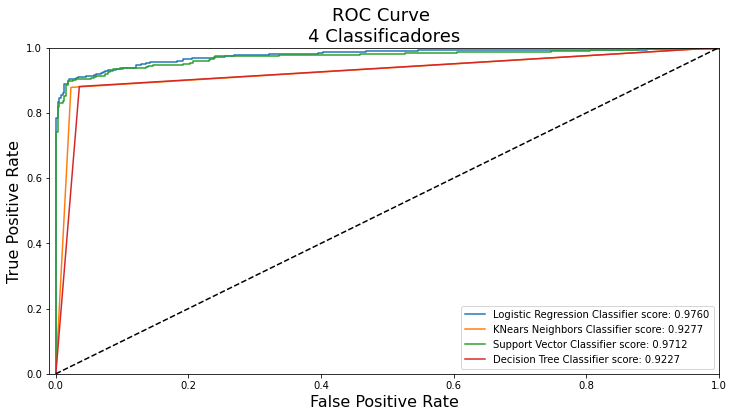

In [ ]:
# False Positive Rate e True Positive Rate de todos os 4 classificadores
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    # Cria a figura
    plt.figure(figsize=(12,6))
    # Título
    plt.title('ROC Curve \n4 Classificadores', fontsize=18)
    # ROC AUC scores
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    # Linha central
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    # Legenda do eixo X
    plt.xlabel('False Positive Rate', fontsize=16)
    # Legenda do eixo y
    plt.ylabel('True Positive Rate', fontsize=16)

    plt.legend()


graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

Apesar dos modelos **LogisticRegression** e **SVC** possuirem scores próximos, **LogisticRregression** continua se saindo melhor em relação aos outros.

# Um olhar mais atento à LogisticRegression

- **True Positive:** classificação correta de transação fraudulenta
- **False Positive:** classificação incorreta de transação fraudulenta
- **True Negative:** classificação correta de transação não fraudulenta
- **False Negative:** classificação incorreta de transação não fraudulenta
- **Precision:** True Positives / (True Positives + False Positives)
- **Recall:** True Positivies / (True Positives + False Negatives)
- A **Precision** mede o quão preciso o modelo é em detectar transações fraudulentas, enquanto o **Recall** é a quantidade de transações fraudulentas o modelo é capaz de detectar.

### Curva ROC

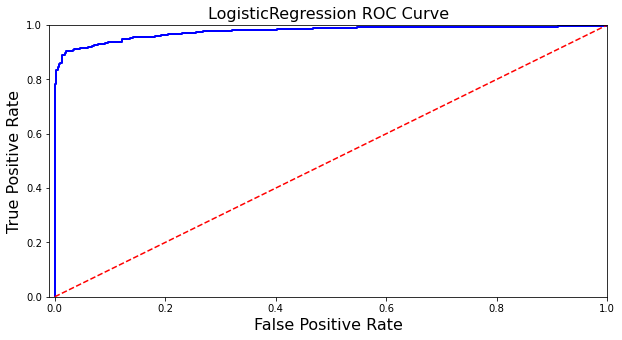

In [ ]:
def log_roc_curve(log_fpr, log_tpr):
    # Cria a figura
    plt.figure(figsize=(10, 5))
    # Título
    plt.title('LogisticRegression ROC Curve', fontsize=16)

    # FPR e TPR na cor azul
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    # Linha central na cor vermelha
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01, 1, 0, 1])


log_roc_curve(log_fpr, log_tpr)
plt.show()

### Scores

In [ ]:
precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

# Predições
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))

print('---' * 45)

# Como deveria ser
print('Como deveria ser:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))

Overfitting: 

Recall Score: 0.92
Precision Score: 0.81
F1 Score: 0.86
Accuracy Score: 0.86
---------------------------------------------------------------------------------------------------------------------------------------
Como deveria ser:

Accuracy Score: 0.82
Precision Score: 0.00
Recall Score: 0.15
F1 Score: 0.00


In [ ]:
# Média de precision-recall
undersample_y_score = log_reg.decision_function(original_Xtest)
undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(undersample_average_precision))

Average precision-recall score: 0.08


Text(0.5, 1.0, 'Undersampling Precision-Recall curve: \nAverage Precision-Recall score = 0.08')

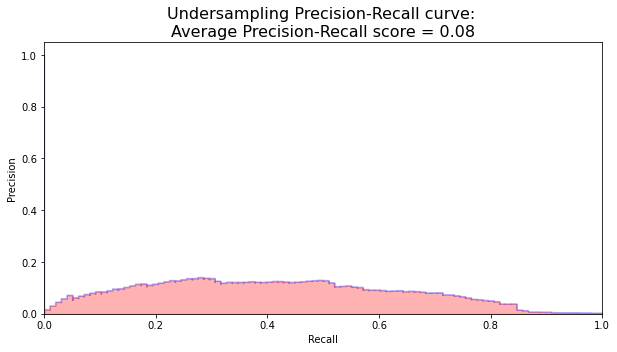

In [ ]:
fig = plt.figure(figsize=(10, 5))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='b', alpha=0.3, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Undersampling Precision-Recall curve: \nAverage Precision-Recall score = {0:0.2f}'.format(undersample_average_precision), fontsize=16)

# Técnica SMOTE (Oversampling)

**SMOTE** significa "Synthetic Minority Over-sampling Technique". Ao contrário do "undersampling" aleatório, SMOTE cria novos pontons sintéticos com o intuito de tornar as classes balanceadas e é uma das técnicas alternativas para lidar com datasets desbalanceados.

- Resolve o desbalanceamento de classes: SMOTE cria pontos sintéticos da classe minoritária para alcançar o balanceamento entre a classe minoritária e majoritária
- Localização dos pontos sintéticos: SMOTE calcula a distância dos vizinhos mais próximos da classe minoritária e cria pontos sintéticos nessas distâncias
- Efeito final: mais informações são mantidas, já que não precisamos excluir nenhuma linha ,diferente da undersampling aleatória.
- Accuracy/Time tradeoff: embora o SMOTE provavelmente seja mais preciso que a "undersampling" aleatória, levará mais tempo para ser executado.

In [ ]:
print('Tamanho do X (treino): {} | Tamanho do y (treino): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Tamanho do X (teste): {} | Tamanho do y (teste): {}'.format(len(original_Xtest), len(original_ytest)))

# Lista para armazenar os scores
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Parâmetros da Logistic Regression
log_reg_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Randomized SearchCV
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementação do SMOTE
# Cross-validation da maneira correta
for train, test in sss.split(original_Xtrain, original_ytrain):
    # Pipeline
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE durante a validação cruzada
    # Treinamento do modelo
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    # Melhores parâmetros
    best_est = rand_log_reg.best_estimator_
    # Predições
    prediction = best_est.predict(original_Xtrain[test])

    # Armazena os "scores" nas listas criadas anteriormente
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))

# Exibe os "scores"
print('---' * 40)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Tamanho do X (treino): 227846 | Tamanho do y (treino): 227846
Tamanho do X (teste): 56961 | Tamanho do y (teste): 56961
------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9706777386636128
precision: 0.06599211904303173
recall: 0.9137617656604998
f1: 0.12191022340459201
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
labels = ['Não fraudulenta', 'fraudulenta']

# Predição com SMOTE
smote_prediction = best_est.predict(original_Xtest)
# Printa a "classification report"
print(classification_report(original_ytest, smote_prediction, target_names=labels))

                 precision    recall  f1-score   support

Não fraudulenta       1.00      0.99      0.99     56863
    fraudulenta       0.11      0.86      0.20        98

       accuracy                           0.99     56961
      macro avg       0.56      0.92      0.60     56961
   weighted avg       1.00      0.99      0.99     56961



# LogisticRegression com os dados de teste

A **confusion matrix (matriz de confusão)** consiste em:
- True Negatives (quadrado superior esquerdo): número de classificações corretas da classe 0 (transação não fraudulenta)
- False Negatives (quadrado superior direito): número de classificações incorretas da classe 0 (transação não fraudulenta)
- False Positives (quadrado inferior esquerdo): número de classificações incorretas da classe 1 (transação fraudulenta)
- True Positives (quadrado inferior direito): número de classificações corretas da classe 1 (transação fraudulenta).

A validação final do modelos modelos de classificação será feita nos dados que passaram pela **random undersampling** e não nos dados originais.

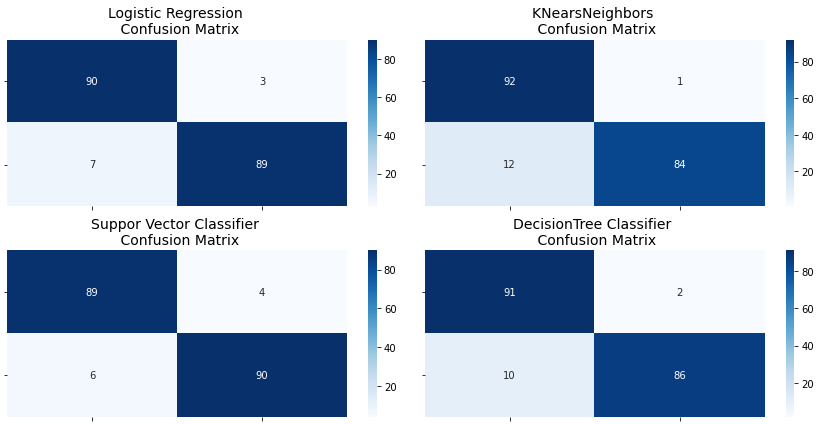

In [ ]:
# Logistic Regression treinado com SMOTE
y_pred_log_reg = best_est.predict(X_test)

# Outros modelos com undersampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

# Matriz de confusão de todos os modelos
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

# Cria a figura e os axes
fig, ax = plt.subplots(2, 2,figsize=(12,6))

# Exibe a matriz de confusão do modelo Logistic Regression
sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.Blues)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Exibe a matriz de confusão do modelo Knears Neighbors
sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.Blues)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Exibe a matriz de confusão do modelo SVC
sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.Blues)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

# Exibe a matriz de confusão do modelo Decision Tree
sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.Blues)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.tight_layout()
plt.show()

In [ ]:
# classification_reports de todos os modelos

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('---' * 40)

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('---' * 40)

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('---' * 40)

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        93
           1       0.97      0.93      0.95        96

    accuracy                           0.95       189
   macro avg       0.95      0.95      0.95       189
weighted avg       0.95      0.95      0.95       189

------------------------------------------------------------------------------------------------------------------------
KNears Neighbors:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93        93
           1       0.99      0.88      0.93        96

    accuracy                           0.93       189
   macro avg       0.94      0.93      0.93       189
weighted avg       0.94      0.93      0.93       189

------------------------------------------------------------------------------------------------------------------------
Support Vector Classifier:
              precision    recall  f1-

In [ ]:
# Logistic Regression com "undersampling"
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

# Logistic Regression com SMOTE
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

# Dicionário com os scores das duas técnicas (undersampling e oversampling)
d = {
    'Técnica': ['Random undersampling', 'Oversampling (SMOTE)'],
    'Score': [undersample_score, oversample_score]
}

# Cria um dataframe com o dicionário
final_df = pd.DataFrame(data=d)

# Armazena o "Score" em outra variável
score = final_df['Score']
# Remove a coluna "Score"
final_df.drop('Score', axis=1, inplace=True)
# Insere os dados armazenados anteriormente na segunda coluna
final_df.insert(1, 'Score', score)

final_df

,Técnica,Score
0,Random undersampling,0.878307
1,Oversampling (SMOTE),0.988062


A técnica de **oversamplig (SMOTE)** obteve um resultado bem superior à técnica de **random undersampling**. Isso pode ter ocorrido pelo fato de que durante o balanceamente dos dados com **undersampling** removeu diversos exemplos de dados **não fraudulentos**, afim de que as duas classes ficassem com uma quantidade igual de exemplos, e isso ocasionou uma **perda de informações** que poderiam ter sido úteis ao modelo. Já o **SMOTE** não removeu essas informações úteis e sim criou pontos sintéticos de dados **fraudulentos**, ou seja, as informações úteis continuaram presentes no conjunto de dados.

# Redes neurais com undersampling e oversampling (SMOTE)

Nessa seção implementaremos uma rede neural simples (com apenas uma camada oculta) com intuito de verificar se a rede performa bem na predição de transações fraudulentas e não fraudulentas, além de utilizar os dois tipos de reamostragem (undersample e oversample).

Nessa fase final de teste, é importante lembrar que o modelo treinará com os dados utilizando **ambas** as técnicas de reamostragem (**random undersampling** e **oversampling (SMOTE)**) e depois fará as predições utilizando os **dados originais de teste**.

### Criação da rede neural com a técnica "undersampling"

Essa rede neural possui a seguinte arquitetura:
- 1 camada de entrada
- 1 camada oculta
- 1 camada de saída

In [ ]:
# Tamanho da camada de entrada
n_inputs = X_train.shape[1]

# Criação da rede
undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
# Visualização da arquitetura da rede
undersample_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


#### Compilação e treinamento da rede

In [ ]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True)

Epoch 1/20
25/25 [==============================] - 0s 7ms/step - loss: 0.4272 - accuracy: 0.7666 - val_loss: 0.3172 - val_accuracy: 0.8618
Epoch 2/20
25/25 [==============================] - 0s 3ms/step - loss: 0.2904 - accuracy: 0.9007 - val_loss: 0.2670 - val_accuracy: 0.9145
Epoch 3/20
25/25 [==============================] - 0s 3ms/step - loss: 0.2421 - accuracy: 0.9205 - val_loss: 0.2374 - val_accuracy: 0.9145
Epoch 4/20
25/25 [==============================] - 0s 3ms/step - loss: 0.2113 - accuracy: 0.9288 - val_loss: 0.2132 - val_accuracy: 0.9211
Epoch 5/20
25/25 [==============================] - 0s 3ms/step - loss: 0.1868 - accuracy: 0.9371 - val_loss: 0.2003 - val_accuracy: 0.9211
Epoch 6/20
25/25 [==============================] - 0s 3ms/step - loss: 0.1682 - accuracy: 0.9404 - val_loss: 0.1902 - val_accuracy: 0.9211
Epoch 7/20
25/25 [==============================] - 0s 3ms/step - loss: 0.1528 - accuracy: 0.9503 - val_loss: 0.1820 - val_accuracy: 0.9342
Epoch 8/20
25/25 [==

#### Predições

In [ ]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200)

#### Função para exibir a matriz de confusão

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[55716  1147]
 [    9    89]]


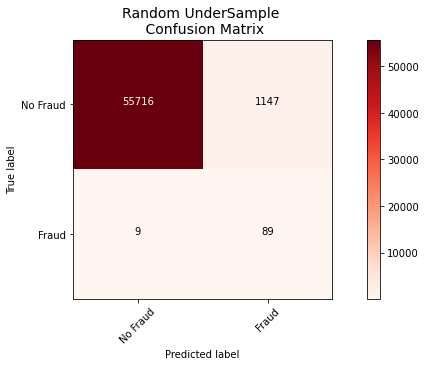

In [ ]:
# Dados originais
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(10,5))

fig.add_subplot(111)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)


### Criação da rede neural com a técnica "oversampling (SMOTE)"

In [ ]:
# SMOTE
sm = SMOTE('minority', random_state=42)

# Treina os dados originais utilizando SMOTE
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

# Modelo com os melhores parâmetros
log_reg_sm = grid_log_reg.best_estimator_
# Treina o modelo utilizando os dados
log_reg_sm.fit(Xsm_train, ysm_train)

LogisticRegression(C=0.1)

In [ ]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

#### Compilação e treinamento da rede

In [ ]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
1214/1214 - 2s - loss: 0.0685 - accuracy: 0.9769 - val_loss: 0.0261 - val_accuracy: 0.9946
Epoch 2/20
1214/1214 - 2s - loss: 0.0122 - accuracy: 0.9972 - val_loss: 0.0067 - val_accuracy: 0.9994
Epoch 3/20
1214/1214 - 2s - loss: 0.0067 - accuracy: 0.9986 - val_loss: 0.0076 - val_accuracy: 0.9990
Epoch 4/20
1214/1214 - 2s - loss: 0.0048 - accuracy: 0.9990 - val_loss: 0.0090 - val_accuracy: 0.9982
Epoch 5/20
1214/1214 - 2s - loss: 0.0040 - accuracy: 0.9992 - val_loss: 0.0021 - val_accuracy: 0.9999
Epoch 6/20
1214/1214 - 2s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0023 - val_accuracy: 0.9998
Epoch 7/20
1214/1214 - 2s - loss: 0.0028 - accuracy: 0.9994 - val_loss: 8.0582e-04 - val_accuracy: 1.0000
Epoch 8/20
1214/1214 - 2s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 9/20
1214/1214 - 2s - loss: 0.0022 - accuracy: 0.9996 - val_loss: 7.4090e-04 - val_accuracy: 1.0000
Epoch 10/20
1214/1214 - 2s - loss: 0.0017 - accuracy: 0.9996 - val_loss: 3

#### Predições

In [ ]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

#### Matriz de confusão

[[56847    16]
 [   31    67]]


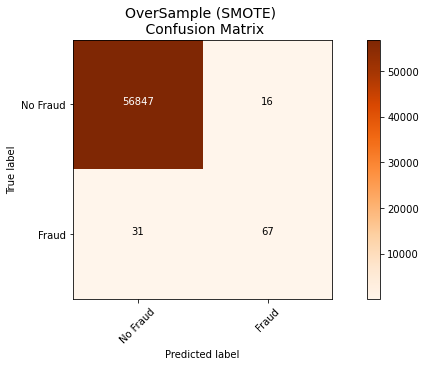

In [ ]:
# DAdos originais
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(10,5))

fig.add_subplot(111)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

# Conclusão

Observando as matrizes de confusão dos **modelos de classificação**, vimos resultados semelhantes, porém como já esperado, o modelo Logistic Regression apresentou um resultado superior aos outros. Já na parte das **redes neurais**, o teste com os dados subamostrados (undersampling) não foi muito satisfatório, e houve uma grande quantidade de falsos positivos. Em uma perspectiva de negócio, esse modelo classificaria diversas transações **não fraudulentas** como sendo **fraudulentas**, o que poderia acabar irritando alguns clientes e prejudicar a reputação da empresa. A rede neural treinada com os dados superasmostrados (oversampling com a técnica SMOTE) obteve resultados satisfatórios, com uma quantidade baixa de Falso Positivos e Falso Negativos. Então, é melhor usar um modelo de classificação "tradicional", como Logistic Regression ou Redes Neurais? Depende muito dos recursos disponíveis. Redes Neurais costumam ter resultados melhores, porém o custo computacional (e consequentemente de capital) para compilar redes neurais mais complexas pode ser bem elevado. Aqui usamos redes simples, com apenas uma camada oculta, mas existem arquiteturas de rede bem mais complexas. Além do mais, o modelo Logistic Regression apresentou bons resultados, e sua implementação requer pouco poder computacional, sendo capaz de ser executado em um PC modesto como o meu.

# Referências

**Todo esse projeto foi baseado no incrível notebook** [Credit Fraud || Dealing with Imbalanced Datasets](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook) criado por [Janio Martinez](https://www.kaggle.com/janiobachmann). Meu trabalho consistiu em analisar, estudar as técnicas e codificar esse notebook, além de traduzir e inserir novos campos de texto e comentários, para melhor compreensão dos códigos. Só tenho a agradecer ao criador do notebook original por disponibilizar um material tão rico e que me permitiu adquirir tanto conhecimento.